On a single image, take raw pixel values, plot correlation heatmap and pairwise plots for interesting markers
Summary:
1) Did heatmap
2) Plotted intensity values (for channels of interest) of random sample of pixels - issue: many zeros
3) Same but for max values rather than random sample - still getting negative correlations - might be colocalisation in region rather than at exact pixel
4) Tried doing Gaussian blur - this resulted in reduction of intensities so results don't make much sense - can Doron improve this?
5) Binned images into 32x32 regions each 64x64 pixels. Took max pixel intensity in each region. Now get more sensible correlations. This is quite crude, but good for a sense of what's going on

In [2]:
# Pre gumpf
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from skimage import filters

from mibidata.mibi_image import MibiImage
from mibidata import color, tiff
from mibitracker import request_helpers

matplotlib.rcParams.update({
    'font.size': 8,
    'axes.grid': False,
})
%matplotlib inline

import seaborn as sns

In [3]:
image = tiff.read('/Users/wershofe/Documents/MIBI_Lung/17-32/tifs/20191011_Lung-CID_FOV25-29 - MassCorrected - Filtered_Point1_RowNumber0_Depth_Profile0.tiff')
      

In [4]:
imarray=np.array(image)
imarray.shape

()

In [25]:
myList = []
for i in range(0,len(image.channels)):
    singChan = image[image.channels[i]]
    singFlat = singChan.flatten()
#     singShort = singFlat[:1000]
    singShort = singFlat
    myList.append(singShort)

In [26]:
df = pd.DataFrame(myList)
df = df.T

In [27]:
covMatrix = df.cov()
corrMatrix = df.corr()

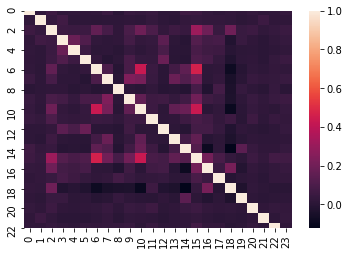

In [28]:
sns.heatmap(corrMatrix)

20200204 Pairwise plots for randomly selected pixels

In [5]:

image = tiff.read("/Users/wershofe/Documents/MIBI_Lung/17-32/tifs/20191014_Lung-CID_FOV30Y10X4 - MassCorrected - Filtered_Point1_RowNumber0_Depth_Profile0.tiff")


In [23]:
excludeChannels = [146, 113, 176, 89] # Excluding [Alexa fluor, beta-tub, HLA class 1A,B,C, dsDNA]
includeChannels = [152,143,158,165,151,175] # CD31, CD4, CD8, Keratin, CD56, CD45
# includeChannels = [143,158] # CD31, CD4, CD8, Keratin, CD56, CD45

In [19]:
# Subsetting
n=10000
singChan = image[image.channels[0]]
singFlat = singChan.flatten()
len(singFlat)
ran_sample = np.random.choice(len(singFlat), n, replace=False)

In [20]:
import sys
import random
myList = []
titles = []
for i in range(0,len(image.channels)):
    if image.channels[i][0] in includeChannels:
        singChan = image[image.channels[i]]
        singFlat = singChan.flatten()
        singShort = singFlat[ran_sample]
        myList.append(singShort)
        title = image.channels[i][1]
        titles.append(title)
myList
# sys.stdout.write("\n Here 1 \n")
df = pd.DataFrame(myList)
df = df.T
df.shape
titles

['CD31', 'CD4', 'CD45', 'CD56', 'CD8', 'Keratin']

In [21]:
df.columns=titles
df[:10]

,CD31,CD4,CD45,CD56,CD8,Keratin
0,0,0,0,0,0,0
1,0,0,0,0,0,1
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,2
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,1,0,0


CPU times: user 2.05 s, sys: 6.69 ms, total: 2.06 s
Wall time: 2.06 s


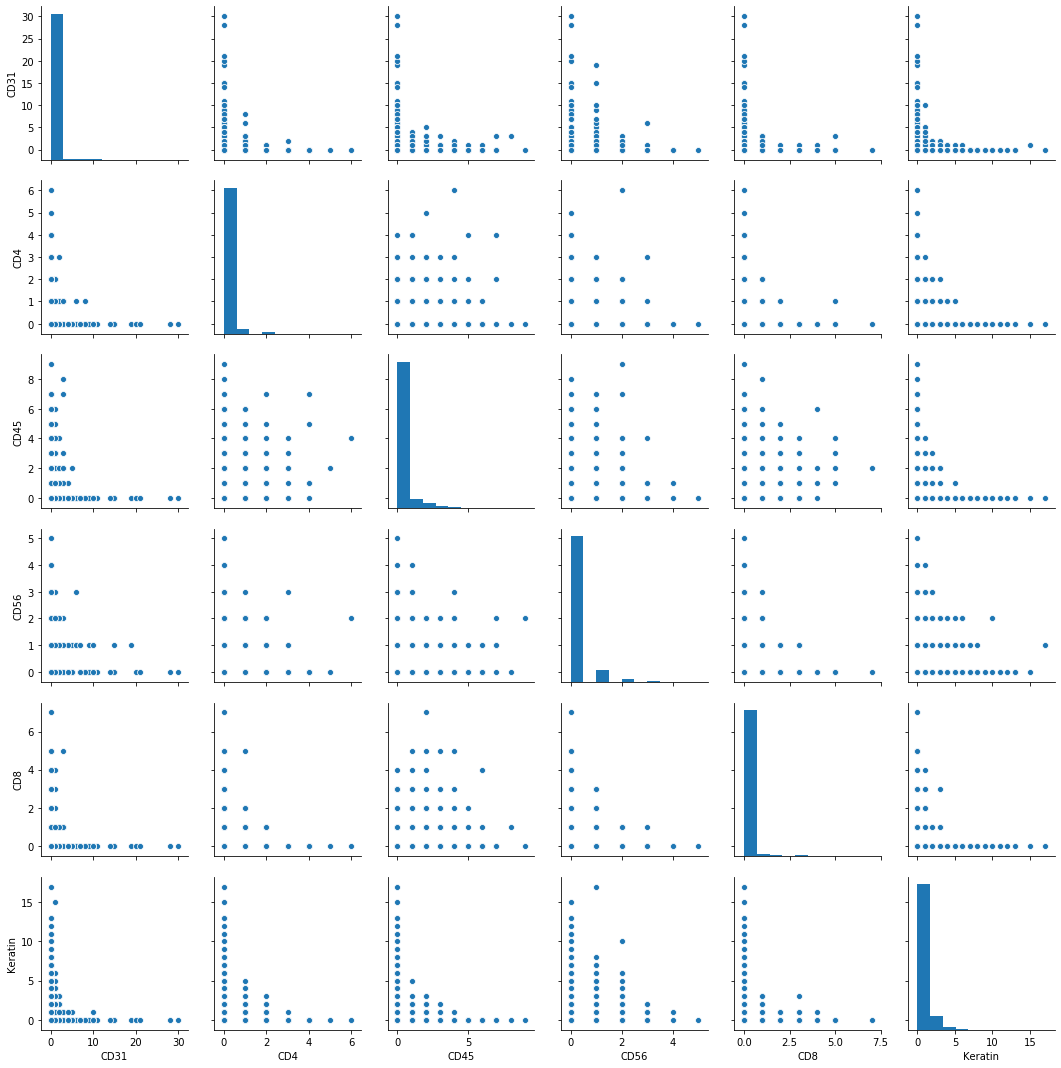

In [57]:
%%time
sns.pairplot(df)

Getting lots of zeros...maybe need to take high intensity values:
1) Get index of 100 max values for channel i

In [9]:
allSamples = []
n=10000
for i in range(0,len(image.channels)):
    if image.channels[i][0] in includeChannels:
        singChan = image[image.channels[i]]
        singFlat = singChan.flatten()
        a = np.percentile(singFlat, 99, axis=0)
        result = np.where(singFlat >=a)
        ranSample = np.random.choice(result[0], n, replace=False)
        allSamples.append(ranSample)
allSamples = np.concatenate(allSamples, axis=0 )
allSamples.shape

(20000,)

In [114]:
myList = []
titles = []
for i in range(0,len(image.channels)):
    if image.channels[i][0] in includeChannels:
        singChan = image[image.channels[i]]
        singFlat = singChan.flatten()
        singShort = singFlat[allSamples]
        myList.append(singShort)
        title = image.channels[i][1]
        titles.append(title)
myList
# sys.stdout.write("\n Here 1 \n")
df = pd.DataFrame(myList)
df = df.T
df.columns=titles
df.shape

(60000, 6)

CPU times: user 4.93 s, sys: 18.8 ms, total: 4.95 s
Wall time: 4.95 s


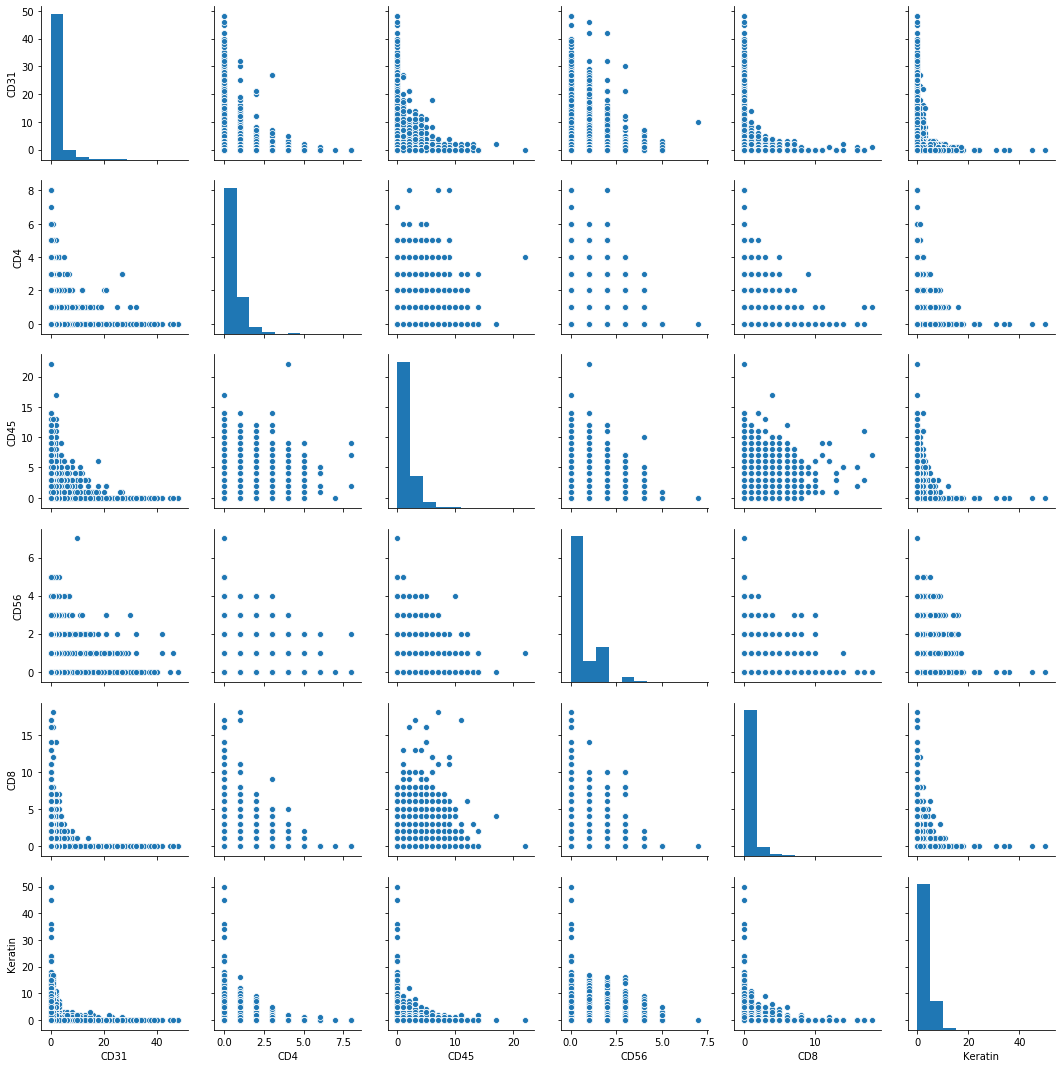

In [115]:
%%time
sns.pairplot(df)

Getting less negative correlations, but still negative. Now will try a Gaussian blur

In [7]:
singChan = image[image.channels[8]]

from scipy.ndimage.filters import gaussian_filter

blurred = gaussian_filter(singChan, sigma=7)
singChan.shape

(2048, 2048)

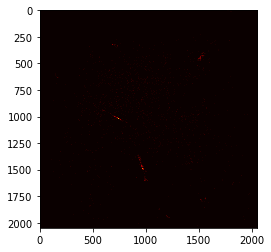

In [11]:
plt.imshow(singChan, cmap='hot', interpolation='nearest')
plt.show()

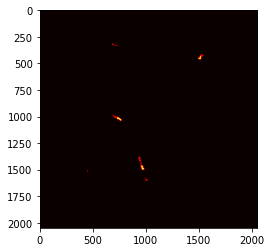

In [12]:
plt.imshow(blurred, cmap='hot', interpolation='nearest')
plt.show()

In [10]:
myList = []
titles = []
for i in range(0,len(image.channels)):
    if image.channels[i][0] in includeChannels:
        singChan = image[image.channels[i]]
        blurred = gaussian_filter(singChan, sigma=0)
        singFlat = blurred.flatten()
        singShort = singFlat[allSamples]
        myList.append(singShort)
        title = image.channels[i][1]
        titles.append(title)
myList
# sys.stdout.write("\n Here 1 \n")
df = pd.DataFrame(myList)
df = df.T
df.columns=titles
df.shape

(20000, 2)

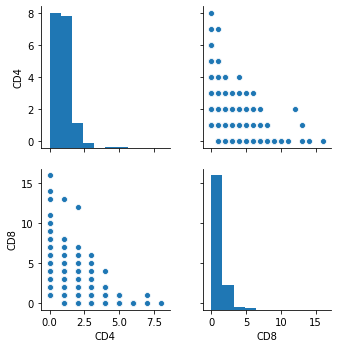

In [11]:
sns.pairplot(df)

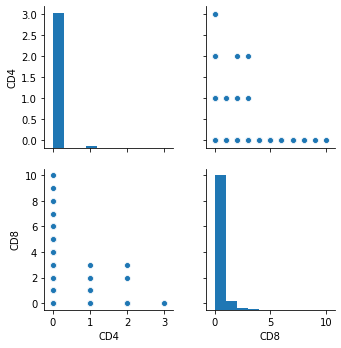

In [12]:
myList = []
titles = []
for i in range(0,len(image.channels)):
    if image.channels[i][0] in includeChannels:
        singChan = image[image.channels[i]]
        blurred = gaussian_filter(singChan, sigma=1)
        singFlat = blurred.flatten()
        singShort = singFlat[allSamples]
        myList.append(singShort)
        title = image.channels[i][1]
        titles.append(title)
myList
# sys.stdout.write("\n Here 1 \n")
df = pd.DataFrame(myList)
df = df.T
df.columns=titles
df.shape
sns.pairplot(df)

TO DO: THIS NEEDS DEBUGGING, THE PAIRWISE PLOTS ABOVE ARE CLEARLY NOT CORRECT. Issue with GB

Doing a rough binning of image channels into regions, taking the max value of each pixel intensity

In [15]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [21]:
# Binning
n=10000
singChan = image[image.channels[13]]
binnedChan = blockshaped(singChan,64,64)
print(binnedChan.shape, singChan.shape)
maxes = binnedChan.max(1).max(1)
maxes.shape
# singFlat = binnedChan.flatten()
# len(singFlat)

(1024, 64, 64) (2048, 2048)


(1024,)

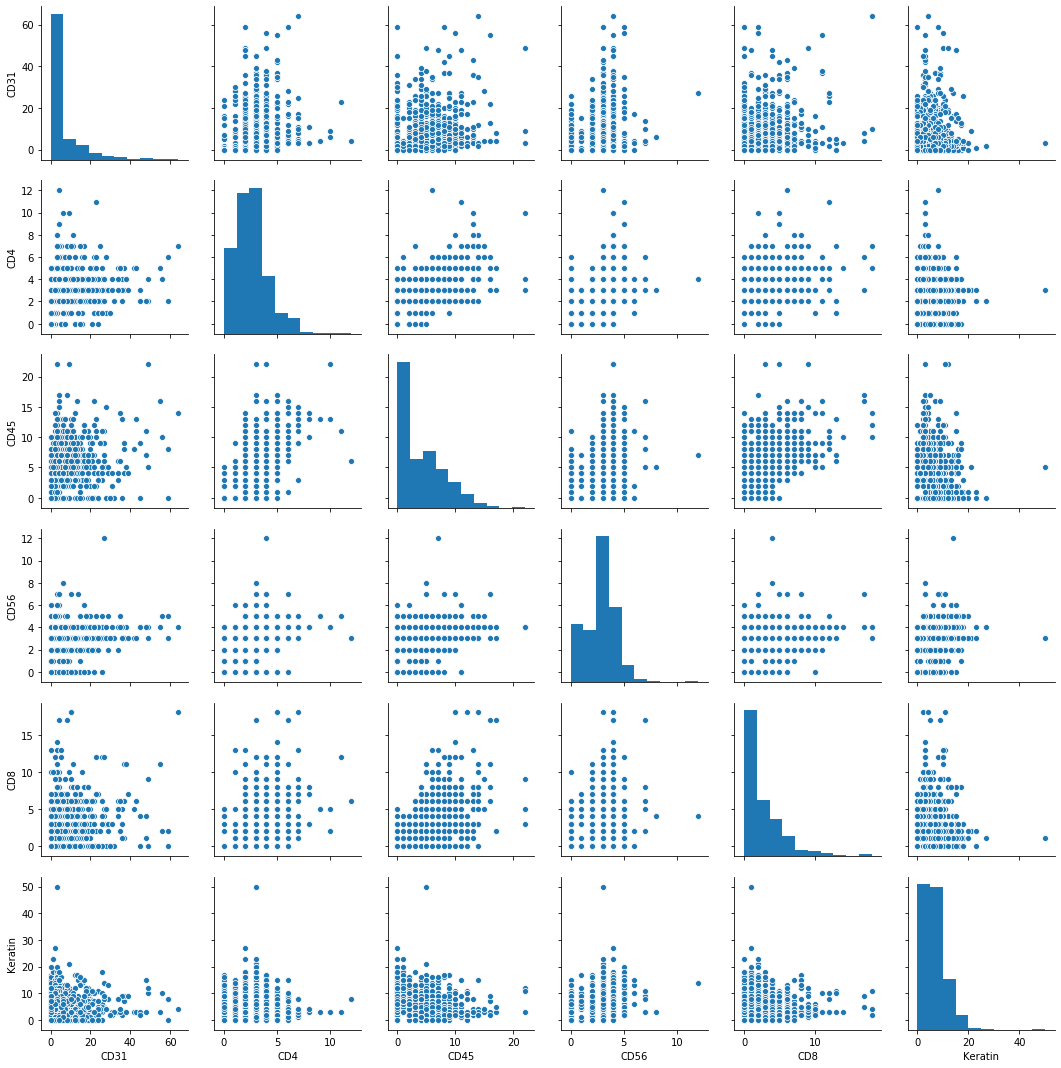

In [24]:
myList = []
titles = []
for i in range(0,len(image.channels)):
    if image.channels[i][0] in includeChannels:
        singChan = image[image.channels[i]]
        binnedChan = blockshaped(singChan,64,64)
        maxes = binnedChan.max(1).max(1)
        myList.append(maxes)
        title = image.channels[i][1]
        titles.append(title)
myList
# sys.stdout.write("\n Here 1 \n")
df = pd.DataFrame(myList)
df = df.T
df.columns=titles
df.shape
sns.pairplot(df)